### MLP

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# Load the Wine dataset
wine = load_wine()
data = wine.data
target = wine.target

In [3]:
data.shape

(178, 13)

In [4]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader for training and testing
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [5]:
# Define a simple feedforward neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(13, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [6]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

# Training loop
for epoch in range(50):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader):.3f}')
    running_loss = 0.0

print('Finished Training')

Epoch 1, Loss: 1.103
Epoch 2, Loss: 1.097
Epoch 3, Loss: 1.081
Epoch 4, Loss: 1.069
Epoch 5, Loss: 1.057
Epoch 6, Loss: 1.055
Epoch 7, Loss: 1.040
Epoch 8, Loss: 1.025
Epoch 9, Loss: 1.021
Epoch 10, Loss: 1.009
Epoch 11, Loss: 0.998
Epoch 12, Loss: 0.985
Epoch 13, Loss: 0.973
Epoch 14, Loss: 0.969
Epoch 15, Loss: 0.950
Epoch 16, Loss: 0.941
Epoch 17, Loss: 0.928
Epoch 18, Loss: 0.910
Epoch 19, Loss: 0.899
Epoch 20, Loss: 0.888
Epoch 21, Loss: 0.876
Epoch 22, Loss: 0.865
Epoch 23, Loss: 0.846
Epoch 24, Loss: 0.836
Epoch 25, Loss: 0.818
Epoch 26, Loss: 0.807
Epoch 27, Loss: 0.791
Epoch 28, Loss: 0.776
Epoch 29, Loss: 0.764
Epoch 30, Loss: 0.747
Epoch 31, Loss: 0.731
Epoch 32, Loss: 0.725
Epoch 33, Loss: 0.706
Epoch 34, Loss: 0.693
Epoch 35, Loss: 0.666
Epoch 36, Loss: 0.657
Epoch 37, Loss: 0.646
Epoch 38, Loss: 0.637
Epoch 39, Loss: 0.623
Epoch 40, Loss: 0.600
Epoch 41, Loss: 0.598
Epoch 42, Loss: 0.584
Epoch 43, Loss: 0.556
Epoch 44, Loss: 0.543
Epoch 45, Loss: 0.524
Epoch 46, Loss: 0.5

In [7]:
# Test the network on the test data
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test set: {100 * correct / total:.2f}%')

Accuracy of the network on the test set: 94.44%


### LSTM

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

In [14]:
# Load the dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-max-temperatures.csv"
# url = "https://github.com/jbrownlee/Datasets/blob/master/daily-max-temperatures.csv"
df = pd.read_csv(url, usecols=[1])
df.head()

,Temperature
0,38.1
1,32.4
2,34.5
3,20.7
4,21.5


In [16]:
# Normalize the dataset
data = df.values.astype(float)
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(data)

# Prepare the dataset for LSTM
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 12
X, y = create_sequences(data_normalized, seq_length)
print(X.shape)
print(y.shape)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Create DataLoader
dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

(3638, 12, 1)
(3638, 1)


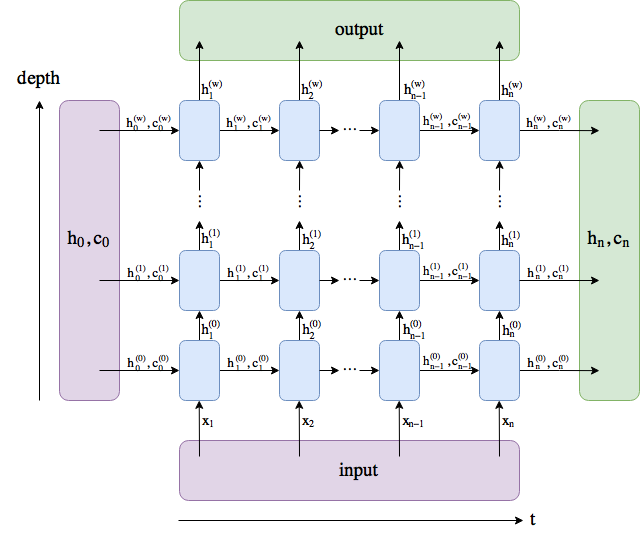

In [17]:
# Define the LSTM network
class LSTMNet(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, output_size=1):
        super(LSTMNet, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        predictions = self.linear(lstm_out[:, -1, :])
        return predictions

net = LSTMNet()

In [22]:
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Training loop
epochs = 50
for epoch in range(epochs):
    epoch_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f'Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}')

print('Finished Training')

Epoch 1/50, Loss: 1.1572
Epoch 2/50, Loss: 1.1330
Epoch 3/50, Loss: 1.1274
Epoch 4/50, Loss: 1.1243
Epoch 5/50, Loss: 1.1243
Epoch 6/50, Loss: 1.1165
Epoch 7/50, Loss: 1.1154
Epoch 8/50, Loss: 1.1138
Epoch 9/50, Loss: 1.1130
Epoch 10/50, Loss: 1.1124
Epoch 11/50, Loss: 1.1083
Epoch 12/50, Loss: 1.1069
Epoch 13/50, Loss: 1.1029
Epoch 14/50, Loss: 1.1078
Epoch 15/50, Loss: 1.1001
Epoch 16/50, Loss: 1.1013
Epoch 17/50, Loss: 1.1037
Epoch 18/50, Loss: 1.0935
Epoch 19/50, Loss: 1.0935
Epoch 20/50, Loss: 1.0904
Epoch 21/50, Loss: 1.0909
Epoch 22/50, Loss: 1.0863
Epoch 23/50, Loss: 1.0911
Epoch 24/50, Loss: 1.0865
Epoch 25/50, Loss: 1.0842
Epoch 26/50, Loss: 1.0806
Epoch 27/50, Loss: 1.0801
Epoch 28/50, Loss: 1.0750
Epoch 29/50, Loss: 1.0770
Epoch 30/50, Loss: 1.0755
Epoch 31/50, Loss: 1.0739
Epoch 32/50, Loss: 1.0689
Epoch 33/50, Loss: 1.0682
Epoch 34/50, Loss: 1.0615
Epoch 35/50, Loss: 1.0647
Epoch 36/50, Loss: 1.0655
Epoch 37/50, Loss: 1.0573
Epoch 38/50, Loss: 1.0565
Epoch 39/50, Loss: 1.

In [23]:
# Make predictions
net.eval()
with torch.no_grad():
    test_inputs = X_tensor[-1].view(1, seq_length, 1)
    predictions = []
    for _ in range(12):
        test_outputs = net(test_inputs)
        predictions.append(test_outputs.item())
        new_input = test_outputs.view(1, 1, 1)
        test_inputs = torch.cat((test_inputs[:, 1:, :], new_input), dim=1)

# Inverse transform the predictions
predicted_values = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

print('Predicted values for the next 12 months:')
print(predicted_values)


Predicted values for the next 12 months:
[[23.76338035]
 [27.78540189]
 [26.15756139]
 [26.11396171]
 [23.82380998]
 [27.58656691]
 [23.68639125]
 [22.87933193]
 [25.95079664]
 [25.0636239 ]
 [24.02738876]
 [23.98802658]]


### CNN

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [ ]:
# Define device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Transformations for the training and testing sets
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the Fashion MNIST dataset
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

# Define the classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

In [9]:
# Define a simple CNN
class CNNNet(nn.Module):
    def __init__(self):
        super(CNNNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        # print(x.shape)
        x = self.pool(F.relu(self.conv1(x)))
        # print(x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        # print(x.shape)
        x = x.view(-1, 64 * 7 * 7)
        # print(x.shape)
        x = F.relu(self.fc1(x))
        # print(x.shape)
        x = self.fc2(x)
        # print(x.shape)
        return x

net = CNNNet().to(device)

In [6]:
data = next(iter(trainloader))
inputs, labels = data
inputs, labels = inputs.to(device), labels.to(device)
p = net(inputs)

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 64, 7, 7])
torch.Size([32, 3136])
torch.Size([32, 512])
torch.Size([32, 10])


In [10]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters(), lr=0.001)

# Training loop
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward() ## calculate gradients
        optimizer.step() ## Update parameters

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 2000 mini-batches
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

Epoch 1, Batch 100, Loss: 0.041
Epoch 1, Batch 200, Loss: 0.028
Epoch 1, Batch 300, Loss: 0.023
Epoch 1, Batch 400, Loss: 0.021
Epoch 1, Batch 500, Loss: 0.021
Epoch 1, Batch 600, Loss: 0.018
Epoch 1, Batch 700, Loss: 0.018
Epoch 1, Batch 800, Loss: 0.017
Epoch 1, Batch 900, Loss: 0.016
Epoch 1, Batch 1000, Loss: 0.017
Epoch 1, Batch 1100, Loss: 0.016
Epoch 1, Batch 1200, Loss: 0.016
Epoch 1, Batch 1300, Loss: 0.015
Epoch 1, Batch 1400, Loss: 0.015
Epoch 1, Batch 1500, Loss: 0.014
Epoch 1, Batch 1600, Loss: 0.014
Epoch 1, Batch 1700, Loss: 0.015
Epoch 1, Batch 1800, Loss: 0.014
Epoch 2, Batch 100, Loss: 0.013
Epoch 2, Batch 200, Loss: 0.013
Epoch 2, Batch 300, Loss: 0.012
Epoch 2, Batch 400, Loss: 0.013
Epoch 2, Batch 500, Loss: 0.011
Epoch 2, Batch 600, Loss: 0.012
Epoch 2, Batch 700, Loss: 0.012
Epoch 2, Batch 800, Loss: 0.012
Epoch 2, Batch 900, Loss: 0.011
Epoch 2, Batch 1000, Loss: 0.012
Epoch 2, Batch 1100, Loss: 0.011
Epoch 2, Batch 1200, Loss: 0.013
Epoch 2, Batch 1300, Loss: 0

In [11]:
# Save the trained model
PATH = './fashion_mnist_cnn.pth'
torch.save(net.state_dict(), PATH)

# Test the network on the test data
correct = 0
total = 0
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f}%')

Accuracy of the network on the 10000 test images: 91.99%
